# Functional Renormalization Group Simulation

In what follows, we simulate the behaviour of the RG of the stochastic field theory around the Marchenko–Pastur (MP) distribution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from pde import CartesianGrid, MemoryStorage, ScalarField
from pde.visualization.movies import movie

plt.style.use('ggplot')
output_dir = Path('sim_analytical')
output_dir.mkdir(exist_ok=True)

from ssd import SSD, TranslatedInverseMarchenkoPastur

## Functional Renormalization Group

We here simulate the behaviour of the functional RG.

In [3]:
# Parameters of the distribution
L = 0.8
sigma = 1.0
xlim_inf = 1.e-9
xlim_sup = 1.0
n_values = 1000
periodic = True
t_range = 300
dt = 1
k2 = 1.7
noise = 0.0
mu1 = 0.0
mu2 = 1.0
mu3 = 0.0
mu4 = 0.0
viz_time = [0, t_range // 12, t_range // 6]

In [4]:
# Create the name of the output files
output_file = f'ssd_analytical_L={L:.2f}_k2={k2:.2f}_mu1={mu1:.2f}_mu2={mu2:.2f}_mu3={mu3:.2f}_mu4={mu4:.2f}'

In [5]:
# Define the distribution
dist = TranslatedInverseMarchenkoPastur(L=L, sigma=sigma)

# Define the grid
grid = CartesianGrid(
    [[xlim_inf, xlim_sup]],
    [n_values],
    periodic=periodic,
)
expression = f'{mu1} + {mu2} * x + {mu3} * x**2 + {mu4} * x**3'
state = ScalarField.from_expression(grid, expression)
bc = 'periodic' if periodic else 'auto_periodic_neumann'

# Initialize a storage
storage = MemoryStorage()
trackers = [
    'progress',
    'steady_state',
    storage.tracker(interval=1),
]

# Define the PDE and solve
eq = SSD(dist=dist, k2=k2, noise=noise, bc=bc)
result = eq.solve(state, t_range=t_range, dt=dt, tracker=trackers)

movie(
    storage,
    output_dir / f'movie_{output_file}.mp4',
    show_time=True,
    movie_args={'framerate': 10},
    plot_args={
        'title': 'Stochastic Signal Detection',
        'ax_style': {
            'xlabel': r'$\chi$',
            'ylabel': r'$\overline{\mathcal{U}}^{~\prime}$',
        },
        'fig_style': {
            'dpi': 150,
        },
    },
)

# Remove the figure from buffer
fig = plt.gcf()
plt.close(fig)

  4%|█▌                                         | 11.0/300.0 [00:00<00:05, 51.74it/s]/home/rf265700/Code/stochastic-signal-detection/venv/lib/python3.10/site-packages/pde/fields/base.py:511: RuntimeWarning: overflow encountered in power
  op(self.data, other, out=result.data)
 38%|███████████████▋                         | 115.0/300.0 [00:00<00:00, 380.05it/s]/home/rf265700/Code/stochastic-signal-detection/venv/lib/python3.10/site-packages/pde/fields/base.py:511: RuntimeWarning: overflow encountered in multiply
  op(self.data, other, out=result.data)
/home/rf265700/Code/stochastic-signal-detection/venv/lib/python3.10/site-packages/pde/fields/base.py:505: RuntimeWarning: invalid value encountered in divide
  op(self.data, other.data, out=result.data)
100%|█████████████████████████████████████████| 300.0/300.0 [00:00<00:00, 649.42it/s]
100%|██████████████████████████████████████████████| 301/301 [00:07<00:00, 38.73it/s]


### Visualisation

We finally visualise the results, as functions of the stochastic time.

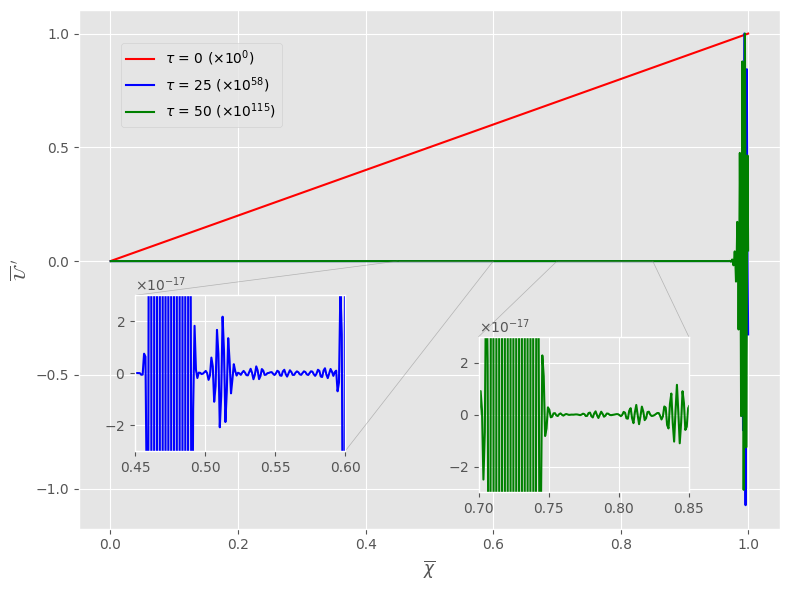

In [6]:
# Visualize the simulation at fixed time steps
x = storage[0].grid.axes_coords[0]
y = [storage[t].data for t in viz_time]
My = [int(np.log10(y_i.max() + 1)) for y_i in y]

y = [y_i / y_i.max() for y_i in y]

fig, ax = plt.subplots(figsize=(8, 6))
C = ['r-', 'b-', 'g-']
for i, y_i in enumerate(y):
    ax.plot(x,
            y_i,
            C[i],
            label=rf'$\tau$ = {viz_time[i]} ($\times 10^{{{My[i]:d}}}$)')
ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
ax.set_xlabel(r'$\overline{\chi}$')
ax.set_ylabel(r'$\overline{\mathcal{U}}^{~\prime}$')

# Create an inset axis to zoom around some values
ax_inset_1 = ax.inset_axes([0.08, 0.15, 0.3, 0.3])
ax_inset_1.plot(x,
                y[1],
                C[1],
                label=rf'$\tau$ = {viz_time[1]} ($\times 10^{{{My[1]:d}}}$)')
ax_inset_1.set_xlim([0.45, 0.60])
ax_inset_1.set_ylim([-3e-17, 3e-17])
ax_inset_1.ticklabel_format(axis='y',
                            style='sci',
                            scilimits=(0, 0),
                            useMathText=True)
ax_inset_1.set_xticks([0.45, 0.50, 0.55, 0.60])
ax_inset_1.set_yticks([-2e-17, 0, 2e-17])
ax.indicate_inset_zoom(ax_inset_1)

ax_inset_2 = ax.inset_axes([0.57, 0.07, 0.3, 0.3])
ax_inset_2.plot(x,
                y[2],
                C[2],
                label=rf'$\tau$ = {viz_time[2]} ($\times 10^{{{My[2]:d}}}$)')
ax_inset_2.set_xlim([0.70, 0.85])
ax_inset_2.set_ylim([-3e-17, 3e-17])
ax_inset_2.ticklabel_format(axis='y',
                            style='sci',
                            scilimits=(0, 0),
                            useMathText=True)
ax_inset_2.set_xticks([0.70, 0.75, 0.80, 0.85])
ax_inset_2.set_yticks([-2e-17, 0, 2e-17])
ax.indicate_inset_zoom(ax_inset_2)

fig.tight_layout()
fig.savefig(output_dir / f'full_values_{output_file}.pdf', dpi=300)
plt.show()
plt.close(fig)

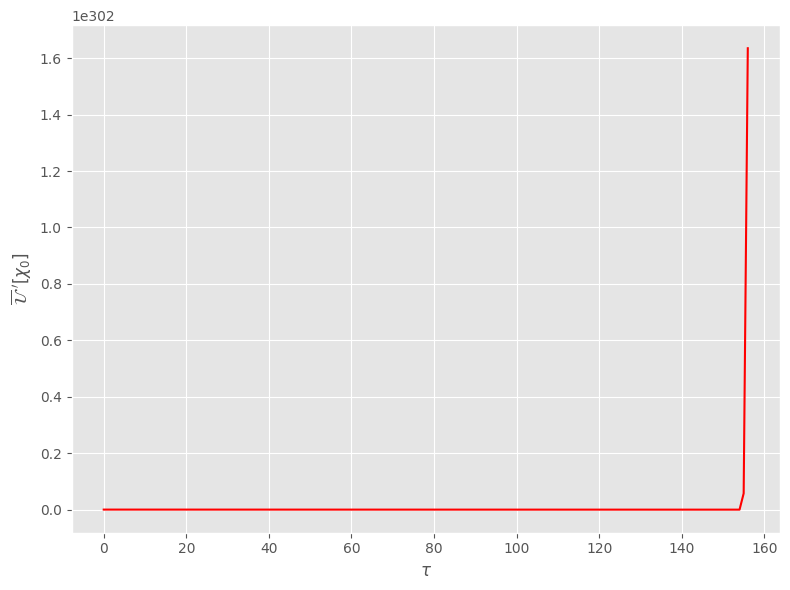

In [7]:
# Display the evolution of the field in 0
chi = 0.5
t = []
y = []

fig, ax = plt.subplots(figsize=(8, 6))
for time, field in storage.items():

    x = field.grid.axes_coords[0]
    idx = (x >= chi).argmax()
    t.append(time)
    y.append(field.data[idx])

ax.plot(t, y, 'r-')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(rf'$\overline{{\mathcal{{U}}}}^{{~\prime}}[{{\chi_0}}]$')

fig.tight_layout()
fig.savefig(output_dir / f'evolution_{output_file}.pdf', dpi=300)
plt.show()
plt.close(fig)